# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


('This image is:', <type 'numpy.ndarray'>, 'with dimesions:', (540, 960, 3))


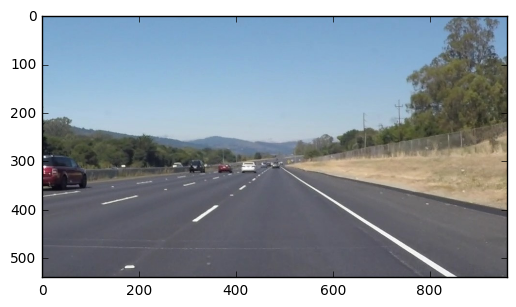

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
class LaneFinder(object):

  CANNY_LOW_THRESHOLD = 64
  CANNY_HIGH_THRESHOLd = 192
  RHO = 1
  THETA = np.pi / 180
  THRESHOLD = 40
  MIN_LINE_LENGTH = 30
  MAX_LINE_GAP = 20
  GAUSSIAN_KERNEL = 5

  def __init__(self, image):
    self.original = image
    self.image    = image
    self.width    = image.shape[1]
    self.height   = image.shape[0]

  def call(self):
    self.grayscale()
    self.gaussian_blur()
    self.canny()
    self.remove_noise()
    self.region_of_interest()
    self.hough_lines()
    self.weighted_img()

  def grayscale(self):
    self.image = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

  def canny(self):
    """Applies the Canny transform"""
    self.image = cv2.Canny(self.image, self.CANNY_LOW_THRESHOLD, self.CANNY_HIGH_THRESHOLd)

  def remove_noise(self):
    self.image = cv2.dilate(self.image, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))

  def gaussian_blur(self):
    """Applies a Gaussian Noise kernel"""
    self.image = cv2.GaussianBlur(self.image, (self.GAUSSIAN_KERNEL, self.GAUSSIAN_KERNEL), 0)

  def region_of_interest(self):
    #defining a blank mask to start with
    mask = np.zeros_like(self.image)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    ignore_mask_color = self.get_ignore_mask_color()
    #define vertices for the needed region (left and right lane)
    vertices = self.generate_vertices()
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    self.image = cv2.bitwise_and(self.image, mask)

  def get_ignore_mask_color(self):
    if len(self.image.shape) > 2:
      channel_count = self.image.shape[2]
      ignore_mask_color = (255,) * channel_count
    else:
      ignore_mask_color = 255
    return ignore_mask_color

  def generate_vertices(self):
    vertices = np.array([[
        (100, self.height),
        (400, 330),
        (550, 330),
        (900, self.height)
    ]], dtype=np.int32)

    return vertices

  def draw_lines(self, img, lines, color=[255, 0, 0], thickness=5):
    for line in lines:
      for x1,y1,x2,y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

  def hough_lines(self):
    self.lines = cv2.HoughLinesP(
        self.image,
        self.RHO,
        self.THETA,
        self.THRESHOLD,
        np.array([]),
        minLineLength=self.MIN_LINE_LENGTH,
        maxLineGap=self.MAX_LINE_GAP
    )

    line_img = np.zeros((self.height, self.width, 3), dtype=np.uint8)

    if self.lines != None:
      lines2 = []
      for line in self.lines:
        for x1,y1,x2,y2 in line:
          k = float(y2-y1)/(x2-x1)
          if y1 > y2:
            x1 = int(x2 + (self.height-y2)/k)
            y1 = self.height
          elif y1 < y2:
            x2 = int(x1 + (self.height-y1)/k)
            y2 = self.height
          lines2.append([[x1, y1, x2, y2]])

      self.draw_lines(line_img, lines2)

    self.image = line_img


  def weighted_img(self, a=0.8, b=1., g=0.):
    self.image = cv2.addWeighted(self.original, a, self.image, b, g)

  def show(self):
    plt.imshow(self.image)
    plt.show()


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:89: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


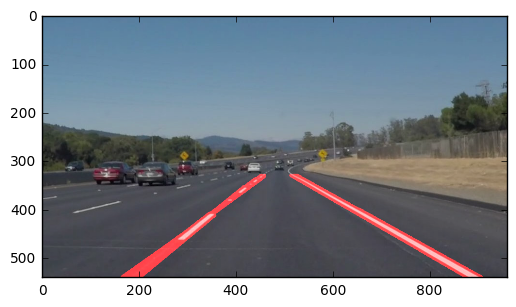

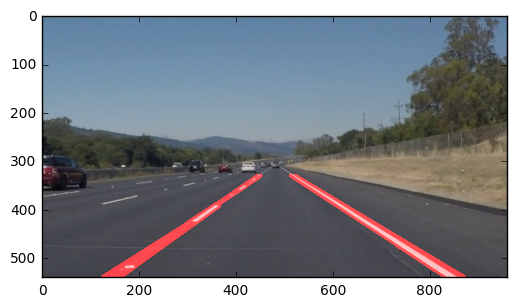

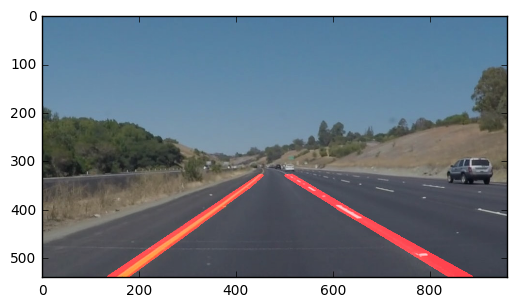

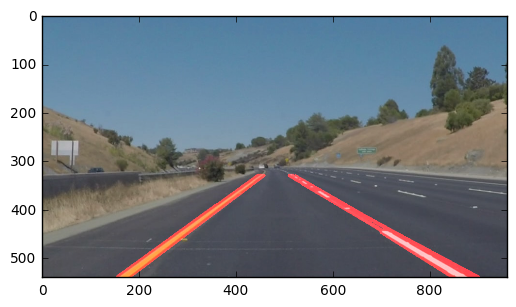

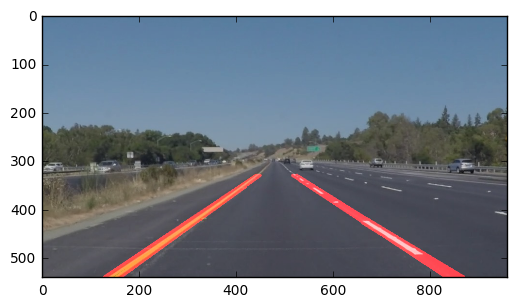

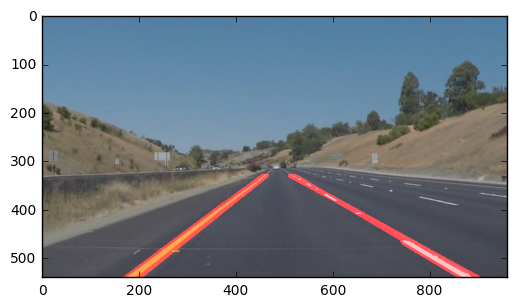

In [8]:
def load_image(filename):
  return mpimg.imread('test_images/%s' % filename)

for image in os.listdir("test_images/"):
  finder = LaneFinder(load_image(image))
  finder.call()
  finder.show()




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    finder = LaneFinder(image)
    finder.call()
    return finder.image


Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 51.07it/s]     | 6/222 [00:00<00:04, 53.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.72 s, sys: 580 ms, total: 4.3 s
Wall time: 4.85 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 49.53it/s]     | 5/682 [00:00<00:14, 48.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.6 s, sys: 1.83 s, total: 13.5 s
Wall time: 14.2 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## My Thoughts

This was a very interesting project. I used OOPs best practise to create a resuable class `LaneFinder` that contains all the logic for processing one image (like canny, blur, and hough) and then draw the lines. 

The class does the follwings: 

- Calculate the region of interest based on the image dimensions.
- Conver the image to grayscale and apply a small gaussian blur.
- Run Canny edge detection to detect edges and give a black and white image.
- Remove the noise by applying dilation effect on the image to bleed some lines which are close together into one line the hough transform will recognize.
- Run a Hough transform on the edges.
- Remove lines with unacceptable slopes.
- Draw the lines and return the image.

Some issues i'm facing:

- The main issue that the hough transform can become biased by many more lines existing.
- At some cases, left or right Hough line would be obviously not fit with the lane, too steep or too flat.
- At the moment I'm providing the threshold after trial and error but ideally the computer should understand how to get the threshold automatically to filter points and slopes.



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.94it/s]     | 3/251 [00:00<00:10, 23.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.8 s, sys: 1.84 s, total: 12.6 s
Wall time: 14.1 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))